# Code test

This jupyter notebook is for testing the functions for some analytical solvable cases.

## Libraries

In [1]:
# Library for linear algebra
import numpy as np
from numpy import linalg
from numpy import random
# Library and functions for the plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
# Library for precompiled (and faster) code
import numba as numba
from numba import njit
# Library for optimization
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
# Library for error function
from scipy import special
# Library for curve fitting
from scipy.optimize import curve_fit

## 1 D test

In [2]:
@njit(fastmath=True)
def state(q): #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    state = 0  # Transition state
    if q > 1.0:
        # Product state
        state = 1
    if q < 0.0:
        # Reactant state
        state = -1
    return state

### First test: no potential

In [3]:
@njit(fastmath=True)
def potential(q):
    return 0.0

@njit(fastmath=True)
def force(q):
    return 0.0

In [4]:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
    # Define preliminary variables
    q = np.empty(isteps, dtype=np.float64)
    M = np.empty((isteps,2,2), dtype=np.float64)
    q[0] = 0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        ## Evaluate evolution of the system
        f = force(q[i])
        # Linear combination of committors
        z0 = Guess1(q[i])
        z1 = Guess2(q[i])
        z = c[0]*z0+c[1]*z1
        # Gradient components of the committors
        dGx1 = dGuess1(q[i])
        dGx2 = dGuess2(q[i])
        # Matrix M
        M[i,0,0] = dGx1**2
        M[i,1,0] = dGx2*dGx1
        M[i,0,1] = dGx1*dGx2
        M[i,1,1] = dGx2**2
        #print(z0, z1, z[i])
        if z > zmax:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)+kr*(c[0]*dGx1 + c[1]*dGx2)*(zmax - z)*dt
        i += 1
        s = state(q[i])
        
    M *= np.sqrt(2.0*KbT)  # This line technically is not needed because later we rescale everything. Kept for consistency
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty(1, dtype=np.float64)
        out[0] = 0.0
        outM = np.empty((1, 2, 2), dtype=np.float64)
        outM[0,0,0] = 0.0
        outM[0,1,0] = 0.0
        outM[0,0,1] = 0.0
        outM[0,1,1] = 0.0
        return out, outM
        
    return q[j+1:i-1], M[j+1:i-1,:,:]

In [5]:
def Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], dt = 0.002, KbT = 0.1, kr = 1000, isteps = 10000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M = LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = c, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
        del traj, M
    
    # Evaluation of M
    M = np.zeros((2,2), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= Mall.shape[0]
    
    # Minimization part
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=LinearConstraint([1.0, 1.0], 1.0, 1.0),
               options={'verbose': 0}, bounds=Bounds([0.0, 0.0], [1.0, 1.0]))
    
    
    return np.array(cout.x)

In [6]:
def Self_consistent(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], dt = 0.002, KbT = 0.1, kr = 1000, isteps = 10000, jsteps = 1000, ksteps = 30, alpha = 0.5):       
    cout = np.empty((ksteps, 2), dtype=np.float64)
    # Save the initial conditions
    cout[0,0] = c[0]
    cout[0,1] = c[1]
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = c, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sample(Guess1, dGuess1, Guess2, dGuess2, c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

In [7]:
@njit(fastmath=True)
def qLin(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return q
    
@njit(fastmath=True)
def dqLin(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 1.0
   
@njit(fastmath=True)
def qQuadr(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return q**2

@njit(fastmath=True)
def dqQuadr(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 2*q
 
@njit(fastmath=True)
def qCub(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return q**3

@njit(fastmath=True)
def dqCub(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 3*(q**2)
    
@njit(fastmath=True)
def qExp(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return (np.exp(q)-1.0)/(np.exp(1.0)-1.0)

@njit(fastmath=True)
def dqExp(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return np.exp(q)/(np.exp(1.0)-1.0)
    
@njit(fastmath=True)
def qLog(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return np.log(q+1.0)/np.log(2)

@njit(fastmath=True)
def dqLog(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 1.0/(np.log(2)*(1.0+q))
    
@njit(fastmath=True)
def qSqrt(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 1.0
    else:
        return np.sqrt(q)

@njit(fastmath=True)
def dqSqrt(q):
    if q<0.0:
        return 0.0
    elif q>1.0:
        return 0.0
    else:
        return 1.0/(2.0*np.sqrt(q))

Plot of the different committors and their derivatives.

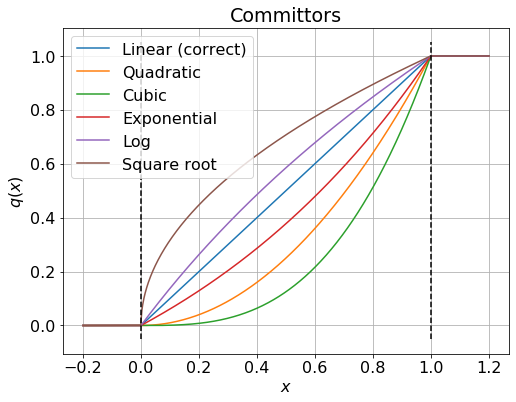

In [8]:
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    y[i] = qLin(x[i])
plt.plot(x,y, label ='Linear (correct)')
for i in range(len(x)):
    y[i] = qQuadr(x[i])
plt.plot(x,y, label ='Quadratic')
for i in range(len(x)):
    y[i] = qCub(x[i])
plt.plot(x,y, label ='Cubic')
for i in range(len(x)):
    y[i] = qExp(x[i])    
plt.plot(x,y, label ='Exponential')
for i in range(len(x)):
    y[i] = qLog(x[i])    
plt.plot(x,y, label ='Log')
for i in range(len(x)):
    y[i] = qSqrt(x[i])    
plt.plot(x,y, label ='Square root')

plt.plot(0.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.title('Committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.legend()
plt.grid()
plt.show()

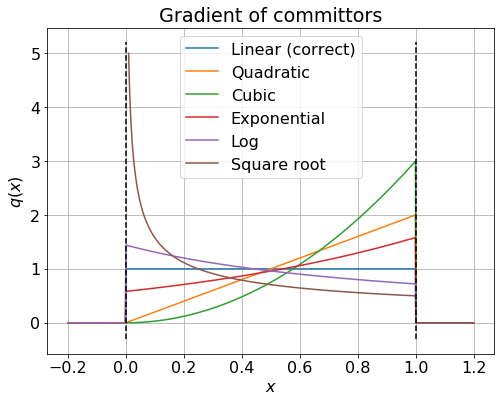

In [9]:
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    y[i] = dqLin(x[i])
plt.plot(x,y, label ='Linear (correct)')
for i in range(len(x)):
    y[i] = dqQuadr(x[i])
plt.plot(x,y, label ='Quadratic')
for i in range(len(x)):
    y[i] = dqCub(x[i])
plt.plot(x,y, label ='Cubic')
for i in range(len(x)):
    y[i] = dqExp(x[i])    
plt.plot(x,y, label ='Exponential')
for i in range(len(x)):
    y[i] = dqLog(x[i])    
plt.plot(x,y, label ='Log')
x = np.linspace(0.01,1.2,1000)
for i in range(len(x)):
    y[i] = dqSqrt(x[i])    
plt.plot(x,y, label ='Square root')
plt.plot(0.0*np.ones(2),np.linspace(-0.3,5.2,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.3,5.2,2),"k--")
plt.title('Gradient of committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.legend()
plt.grid()
plt.show()

In [10]:
KR = 1000
KBT = 0.01
ctry = [1.0, 0.0]
DT = 0.002

Linear guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-6092e34a50c2>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


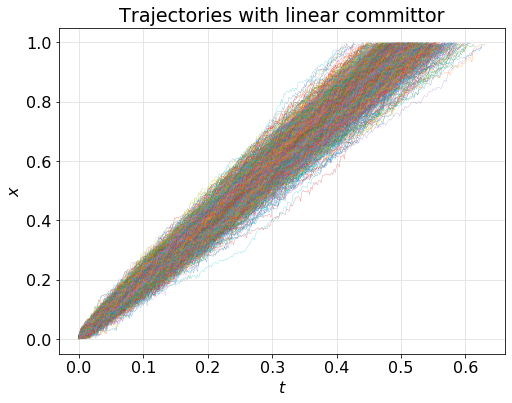

M
[[0.14142136 0.14142136]
 [0.14142136 0.14142136]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-11-78bd3077992a>", line 42:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 1.11e-16, constraint violation: 0.00e+00, execution time: 0.0027 s.
[0.5 0.5]

 Quadratic guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-6092e34a50c2>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

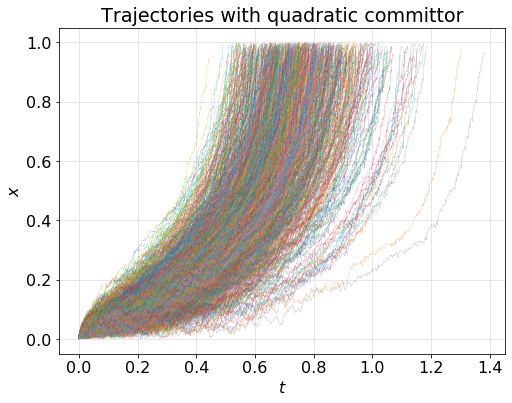

M
[[0.07841414 0.07841414]
 [0.07841414 0.07841414]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-11-78bd3077992a>", line 115:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 4.16e-17, constraint violation: 0.00e+00, execution time: 0.0024 s.
[0.5 0.5]

 Cubic guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-6092e34a50c2>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

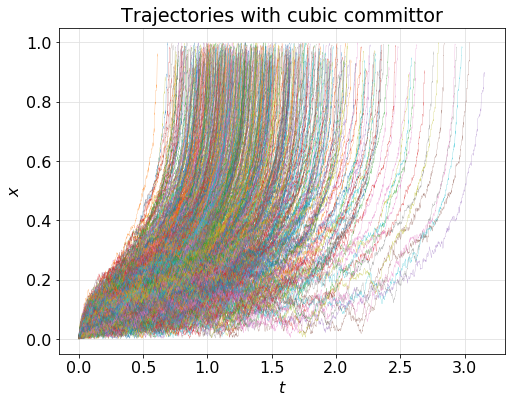

M
[[0.03836584 0.03836584]
 [0.03836584 0.03836584]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-11-78bd3077992a>", line 188:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 4.16e-17, constraint violation: 0.00e+00, execution time: 0.0023 s.
[0.5 0.5]

 Exp guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-6092e34a50c2>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


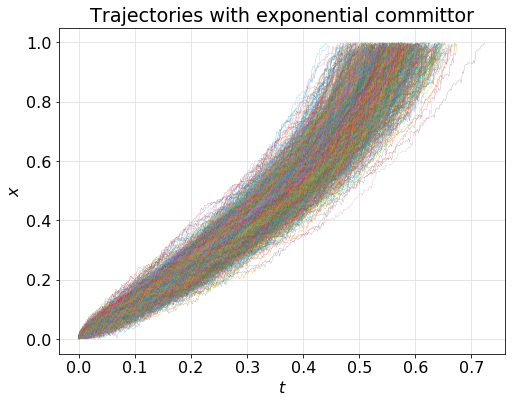

M
[[0.12274271 0.12274271]
 [0.12274271 0.12274271]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-11-78bd3077992a>", line 261:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 9.71e-17, constraint violation: 0.00e+00, execution time: 0.0026 s.
[0.5 0.5]

 Log guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-6092e34a50c2>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


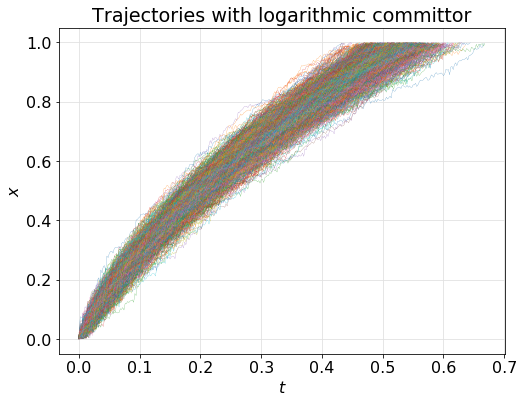

M
[[0.13131689 0.13131689]
 [0.13131689 0.13131689]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-11-78bd3077992a>", line 336:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 1.25e-16, constraint violation: 0.00e+00, execution time: 0.002 s.
[0.5 0.5]

 Sqrt guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-6092e34a50c2>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


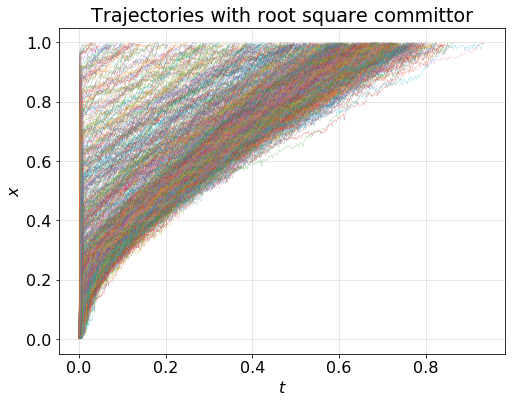

M
[[0.96946714 0.96946714]
 [0.96946714 0.96946714]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-11-78bd3077992a>", line 411:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 7.22e-16, constraint violation: 0.00e+00, execution time: 0.0022 s.
[0.5 0.5]


In [11]:
### Linear guess
print("Linear guess \n")
## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qLin, dGuess2 = dqLin, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajLin = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajLin = np.concatenate((trajLin, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with linear committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ILin = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Quadratic guess
print("\n Quadratic guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qQuadr, dGuess1 = dqQuadr, Guess2 = qQuadr, dGuess2 = dqQuadr, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajQuadr = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajQuadr = np.concatenate((trajQuadr, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with quadratic committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
IQuadr = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Cubic guess
print("\n Cubic guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qCub, dGuess1 = dqCub, Guess2 = qCub, dGuess2 = dqCub, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajCub = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajCub = np.concatenate((trajCub, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with cubic committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ICub = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Exp guess
print("\n Exp guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qExp, dGuess1 = dqExp, Guess2 = qExp, dGuess2 = dqExp, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajExp = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajExp = np.concatenate((trajExp, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with exponential committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
IExp = I(ctry,M)

## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)


### Log guess
print("\n Log guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qLog, dGuess1 = dqLog, Guess2 = qLog, dGuess2 = dqLog, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajLog = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajLog = np.concatenate((trajLog, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with logarithmic committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ILog = I(ctry,M)

## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)


### Sqrt guess
print("\n Sqrt guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qSqrt, dGuess1 = dqSqrt, Guess2 = qSqrt, dGuess2 = dqSqrt, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajSqrt = np.copy(traj)
            Mall = np.copy(M)
            tmp = 1
        if tmp==1:
            trajSqrt = np.concatenate((trajSqrt, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
# Title and labels
plt.title('Trajectories with root square committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= Mall.shape[0]
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ISqrt = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

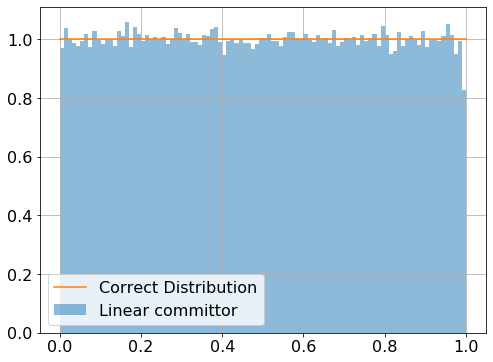

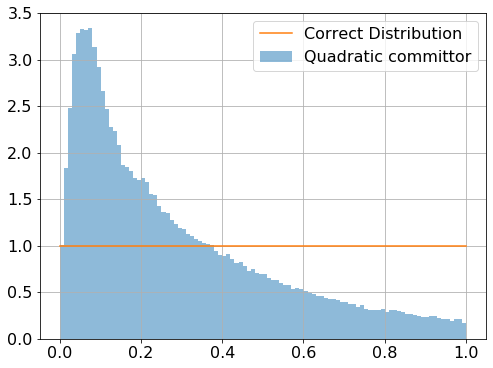

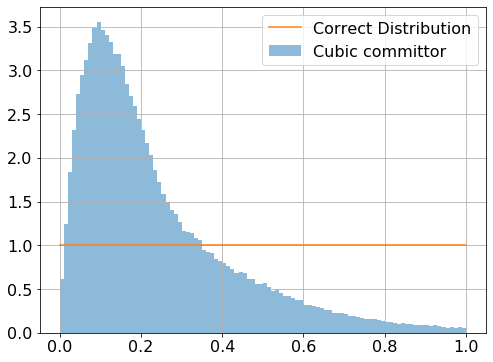

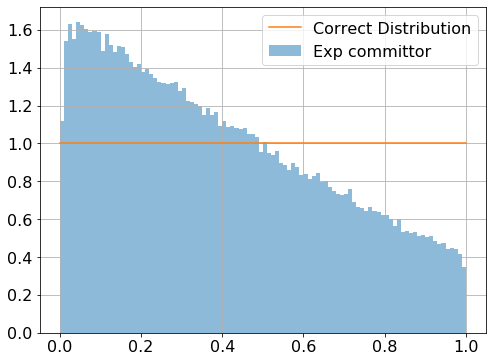

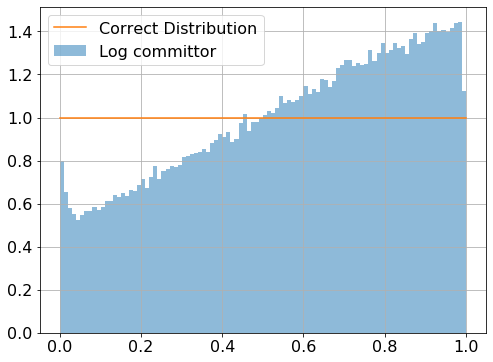

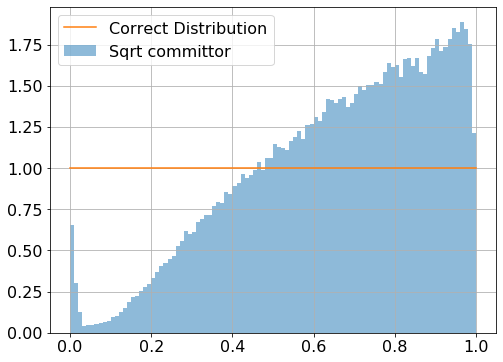

In [12]:
# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajLin, 100, density=True, alpha = 0.5, label = 'Linear committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,x*0+1, label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajQuadr, 100, density=True, alpha = 0.5, label = 'Quadratic committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,x*0+1, label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajCub, 100, density=True, alpha = 0.5, label = 'Cubic committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,x*0+1, label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajExp, 100, density=True, alpha = 0.5, label = 'Exp committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,x*0+1, label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajLog, 100, density=True, alpha = 0.5, label = 'Log committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,x*0+1, label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.hist(trajSqrt, 100, density=True, alpha = 0.5, label = 'Sqrt committor')
# Expected result
x = np.linspace(0,1)
plt.plot(x,x*0+1, label = 'Correct Distribution')
plt.legend()
plt.grid()
plt.show()

In [13]:
KR = 1000
KBT = 0.01
GUESS1 = qLin
DGUESS1 = dqLin
GUESS2 = qQuadr
DGUESS2 = dqQuadr

Cycle =  1
Cycle =  2


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-6092e34a50c2>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  3
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  10
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  21
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

Cycle =  28
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found

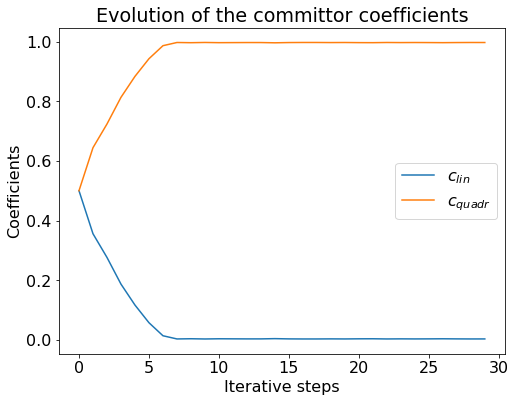

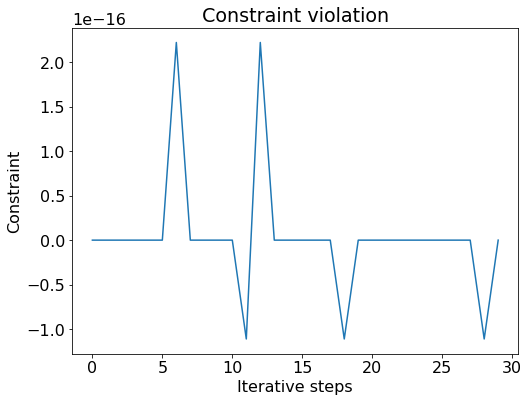

No handles with labels found to put in legend.


Final coefficients
[0.00327445 0.99672555]


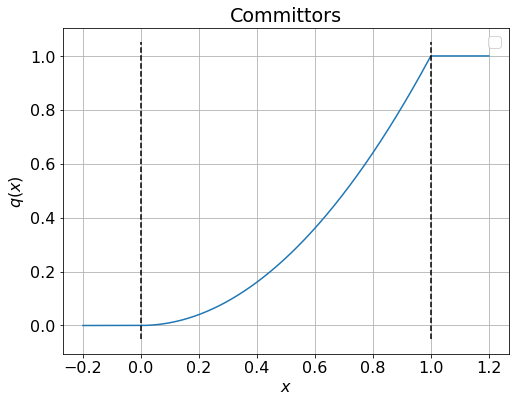

In [14]:
# Self consistent procedure
c = Self_consistent(Guess1 = GUESS1, dGuess1 = DGUESS1, Guess2 = GUESS2, dGuess2 = DGUESS2,c = [0.5, 0.5], kr = KR, KbT = KBT)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(c[:,0], label = r"$c_{lin}$")
plt.plot(c[:,1], label = r"$c_{quadr}$")
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(c[:,0]+c[:,1] - 1.0)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:])
# Print the corresponding committor
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    y[i] = c[-1,0]*GUESS1(x[i]) + c[-1,1]*GUESS2(x[i])
plt.plot(x,y)
plt.plot(0.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.title('Committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.legend()
plt.grid()
plt.show()

### Linear committor as function of KR

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-6092e34a50c2>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


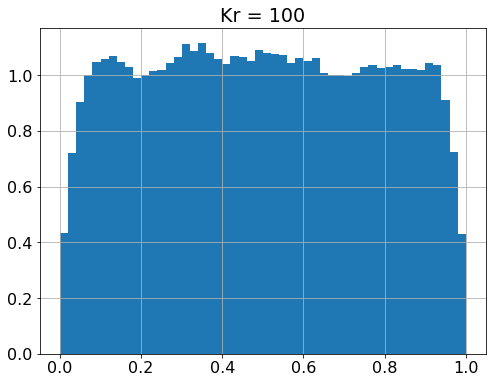

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


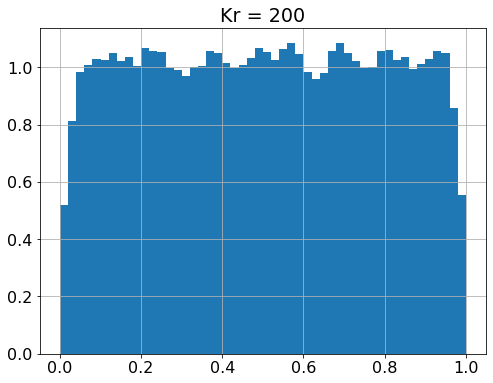

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


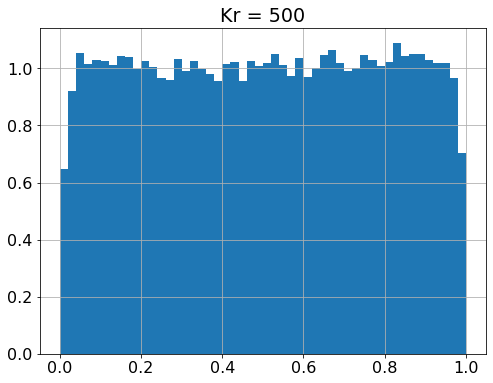

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


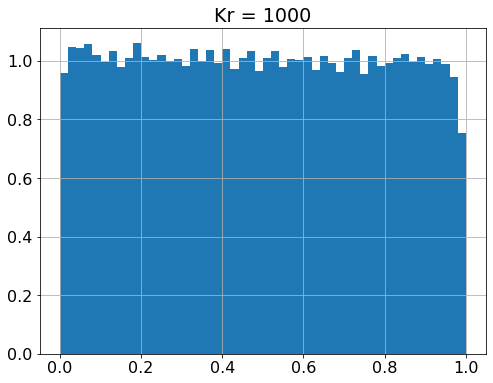

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


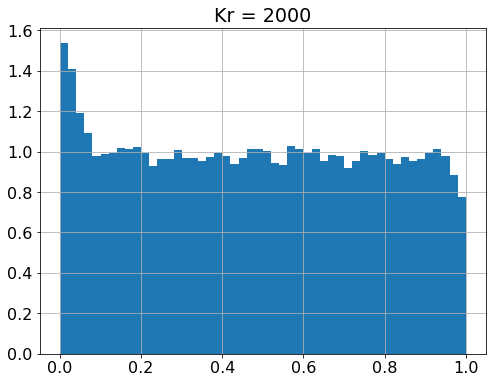

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


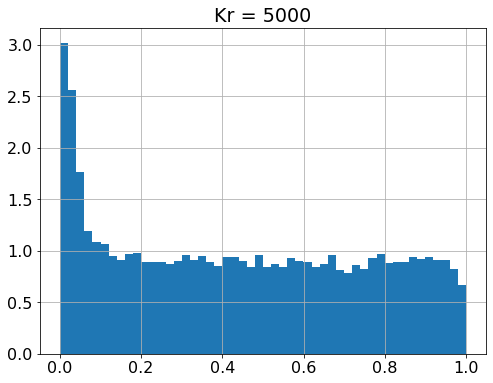

In [15]:
KBT = 0.1
for KR in [100, 200, 500, 1000, 2000, 5000]:
    plt.figure(figsize=(8,6))
    matplotlib.rcParams.update({'font.size': 16})
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qLin, dGuess2 = dqLin, c = [1.0,0.0],kr = KR, KbT = KBT)
        if traj[0] != 0:
            if tmp==0:
                trajLin = np.copy(traj)
                tmp = 1
            if tmp==1:
                trajLin = np.concatenate((trajLin, traj), axis=0)
    # Sampling of transition region - histogram plot
    plt.hist(trajLin, 50, density=True)
    plt.title('Kr = '+str(KR))
    plt.grid()
    plt.show()

### Linear committor as function of KBT

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


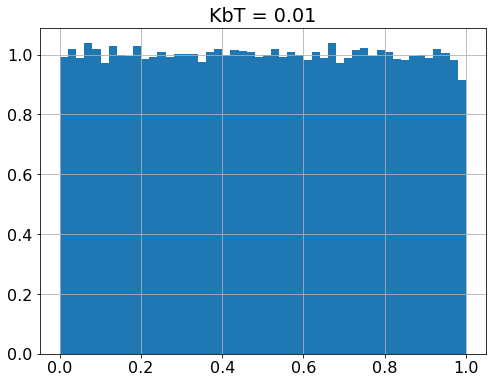

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


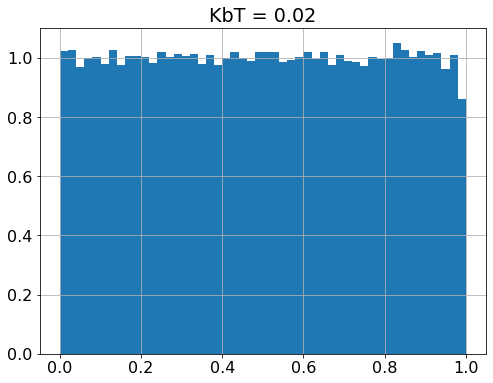

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


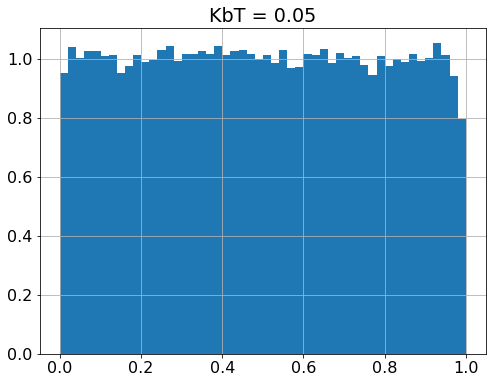

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


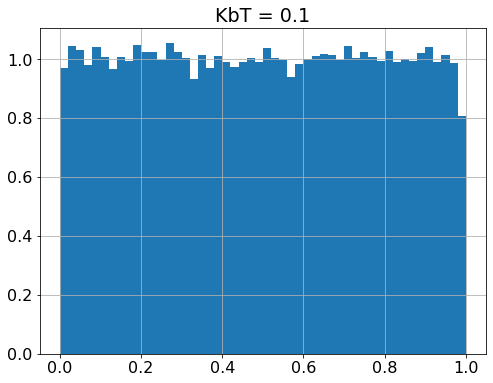

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


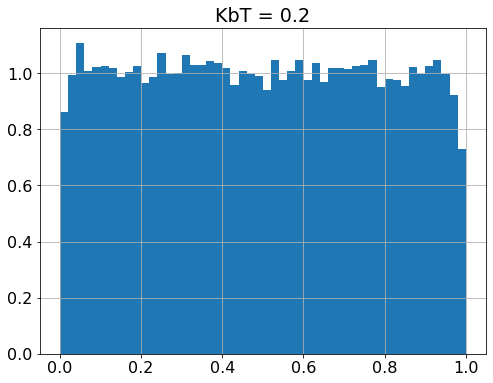

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


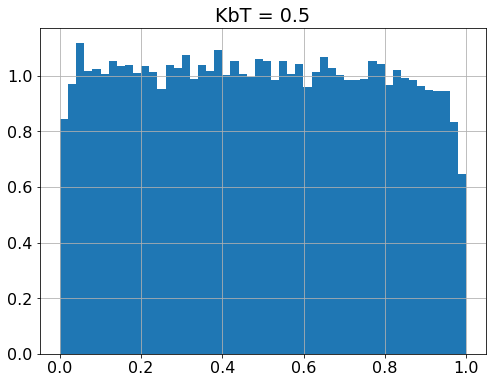

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


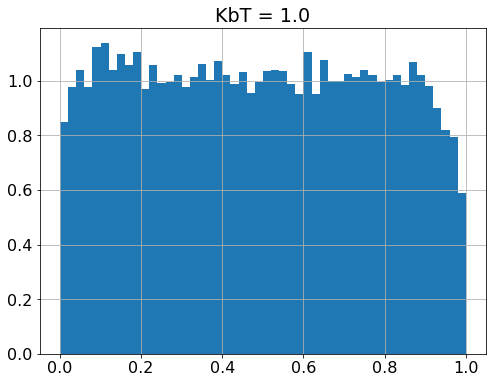

In [16]:
KR = 1000
for KBT in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]:
    plt.figure(figsize=(8,6))
    matplotlib.rcParams.update({'font.size': 16})
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMD(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qLin, dGuess2 = dqLin, c = [1.0,0.0],kr = KR, KbT = KBT)
        if traj[0] != 0:
            if tmp==0:
                trajLin = np.copy(traj)
                tmp = 1
            if tmp==1:
                trajLin = np.concatenate((trajLin, traj), axis=0)
    # Sampling of transition region - histogram plot
    plt.hist(trajLin, 50, density=True)
    plt.title('KbT = '+str(KBT))
    plt.grid()
    plt.show()

### Quadratic committor as function of KR

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-6092e34a50c2>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

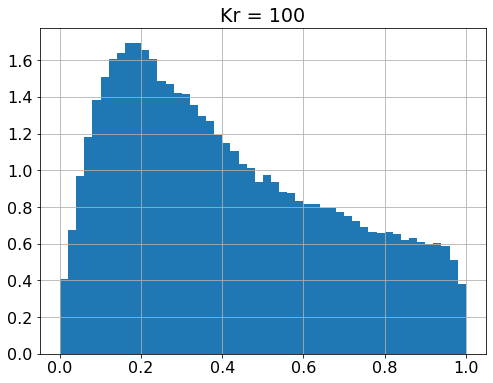

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

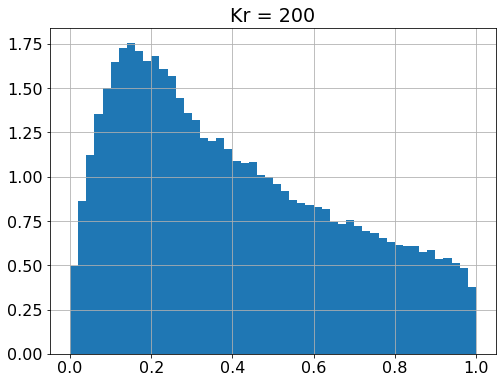

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

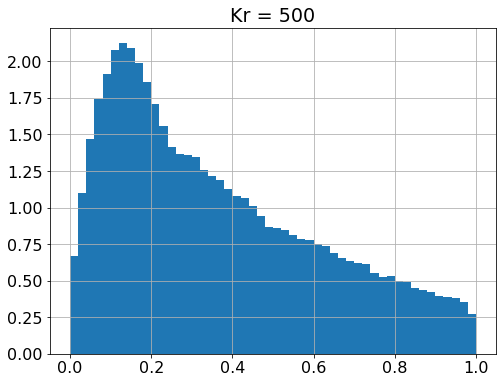

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

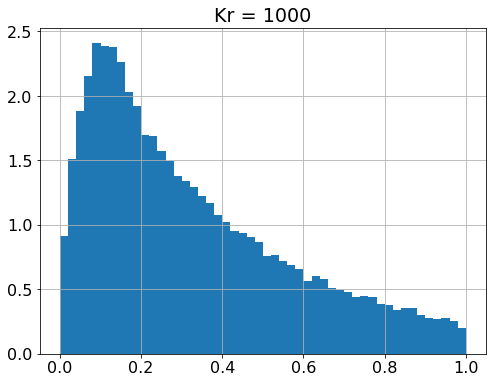

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

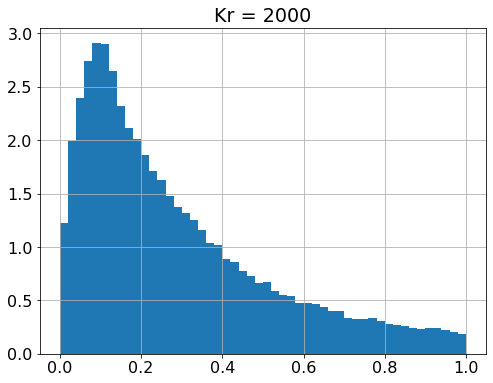

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


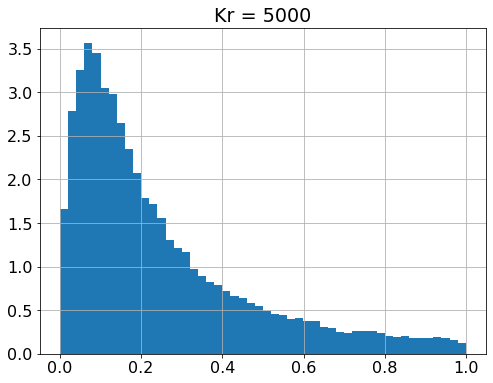

In [17]:
KBT = 0.1
for KR in [100, 200, 500, 1000, 2000, 5000]:
    plt.figure(figsize=(8,6))
    matplotlib.rcParams.update({'font.size': 16})
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMD(Guess1 = qQuadr, dGuess1 = dqQuadr, Guess2 = qQuadr, dGuess2 = dqQuadr, c = [1.0,0.0],kr = KR, KbT = KBT)
        if traj[0] != 0:
            if tmp==0:
                trajQuadr = np.copy(traj)
                tmp = 1
            if tmp==1:
                trajQuadr = np.concatenate((trajQuadr, traj), axis=0)
    # Sampling of transition region - histogram plot
    plt.hist(trajQuadr, 50, density=True)
    plt.title('Kr = '+str(KR))
    plt.grid()
    plt.show()

### Quadratic committor as function of KBT

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

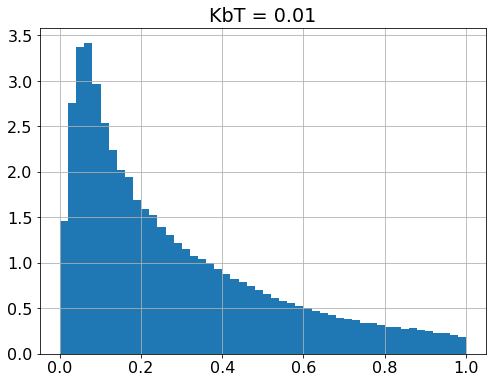

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

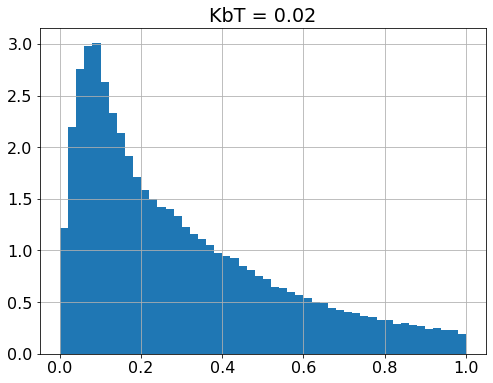

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

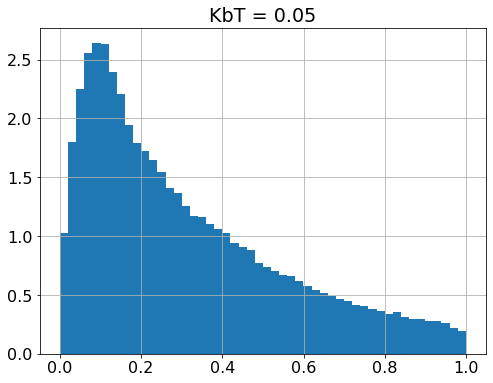

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

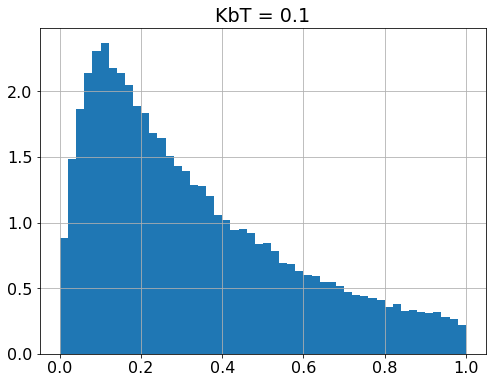

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

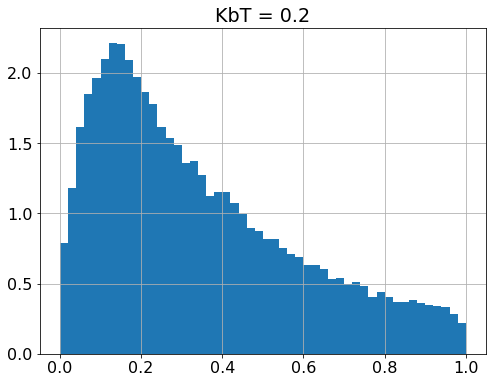

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

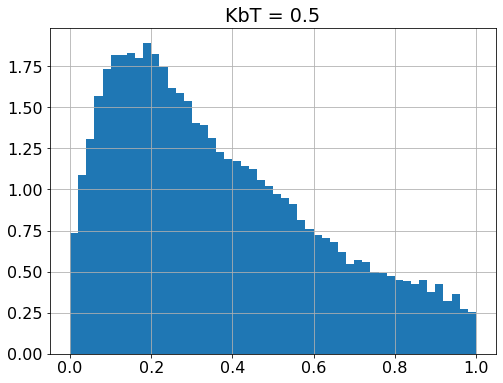

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


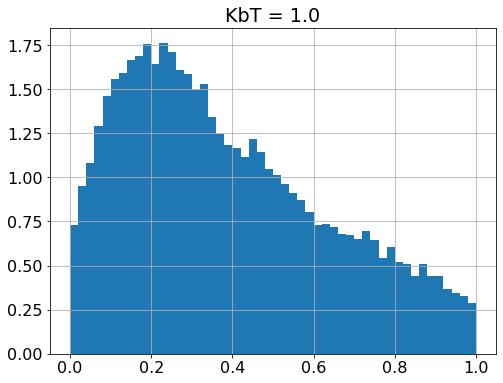

In [18]:
KR = 1000
for KBT in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]:
    plt.figure(figsize=(8,6))
    matplotlib.rcParams.update({'font.size': 16})
    tmp = 0
    # Loop over many iterations with different initial conditions
    for i in range(1000):
        traj, M = LI_RMD(Guess1 = qQuadr, dGuess1 = dqQuadr, Guess2 = qQuadr, dGuess2 = dqQuadr, c = [1.0,0.0],kr = KR, KbT = KBT)
        if traj[0] != 0:
            if tmp==0:
                trajQuadr = np.copy(traj)
                tmp = 1
            if tmp==1:
                trajQuadr = np.concatenate((trajQuadr, traj), axis=0)
    # Sampling of transition region - histogram plot
    plt.hist(trajQuadr, 50, density=True)
    plt.title('KbT = '+str(KBT))
    plt.grid()
    plt.show()

### Fit of quadratic committor

In [19]:
KR = 1000
KBT = 0.01
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qQuadr, dGuess1 = dqQuadr, Guess2 = qQuadr, dGuess2 = dqQuadr, c = [1.0,0.0],kr = KR, KbT = KBT)
    if traj[0] != 0:
        if tmp==0:
            trajQuadr = np.copy(traj)
            tmp = 1
        if tmp==1:
            trajQuadr = np.concatenate((trajQuadr, traj), axis=0)

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

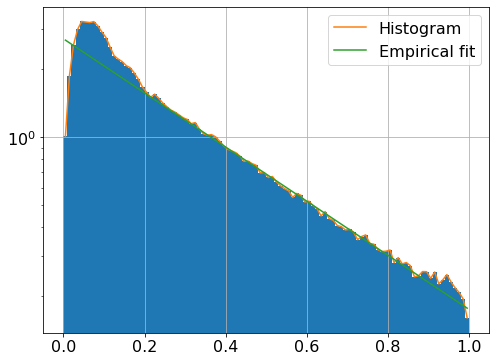

In [20]:
# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
n, bins, patches = plt.hist(trajQuadr, 100, density=True)
y = np.zeros_like(n)
for i in range(len(y)):
    y[i] = 0.5*(bins[i]+bins[i+1])
plt.plot(y,n, label = 'Histogram')
plt.plot(y, np.exp(1-2.75*y), label ='Empirical fit')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

### Fit of cubic committor

In [21]:
KR = 1000
KBT = 0.01
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M = LI_RMD(Guess1 = qCub, dGuess1 = dqCub, Guess2 = qCub, dGuess2 = dqCub, c = [1.0,0.0],kr = KR, KbT = KBT)
    if traj[0] != 0:
        if tmp==0:
            trajCub = np.copy(traj)
            tmp = 1
        if tmp==1:
            trajCub = np.concatenate((trajCub, traj), axis=0)

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-4-6092e34a50c2>", line 2:
@njit(fastmath=True)
def LI_RMD(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

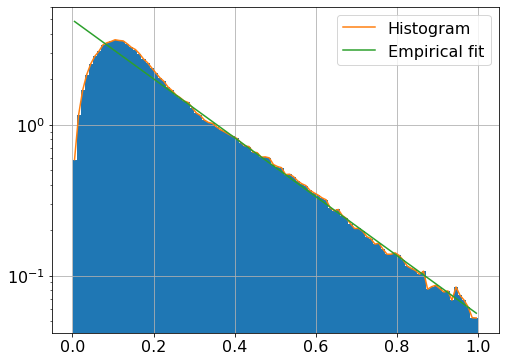

In [22]:
# Sampling of transition region - histogram plot
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
n, bins, patches = plt.hist(trajCub, 100, density=True)
y = np.zeros_like(n)
for i in range(len(y)):
    y[i] = 0.5*(bins[i]+bins[i+1])
plt.plot(y,n, label = 'Histogram')
plt.plot(y, np.exp(1.6-4.5*y), label ='Empirical fit')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

In [23]:
D = np.sqrt(2.0*KBT)
print("Linear")
print("Simulated I:= ",ILin)
print("Theoretical I:= ", D)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLin)):
    tmp = dqLin(np.random.uniform())
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2           
# Average M over all the values obtained with the sampling
M *= D/len(trajLin)
# Calculation of I based on the sampling of the linear committor
ILinResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ILinResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLin)):
    tmp = dqLin(trajLin[k])
    weight = tmp*np.exp(-potential(trajLin[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ILinReweight= I(ctry,M)
print("Reweighted distribution I:= ", ILinReweight)



print("\nQuadratic")
print("Simulated I:= ",IQuadr)
print("Theoretical I:= ", 4.0/3.0*D)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajQuadr)):
    tmp = dqQuadr(np.random.uniform())
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2  
# Average M over all the values obtained with the sampling
M *= D/len(trajQuadr)
# Calculation of I based on the sampling of the linear committor
IQuadrResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", IQuadrResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajQuadr)):
    tmp = dqQuadr(trajQuadr[k])
    weight = tmp*np.exp(-potential(trajQuadr[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
IQuadrReweight= I(ctry,M)
print("Reweighted distribution I:= ", IQuadrReweight)


print("\nCubic")
print("Simulated I:= ",ICub)
print("Theoretical I:= ", 9.0/5.0*D)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajCub)):
    tmp = dqCub(np.random.uniform())
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2        
# Average M over all the values obtained with the sampling
M *= D/len(trajCub)
# Calculation of I based on the sampling of the linear committor
ICubResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ICubResampled) 
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajCub)):
    tmp = dqCub(trajCub[k])
    weight = tmp*np.exp(-potential(trajCub[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ICubReweight= I(ctry,M)
print("Reweighted distribution I:= ", ICubReweight)


print("\nExponential")
print("Simulated I:= ",IExp)
print("Theoretical I:= ", D/2.0*(np.exp(2)-1.0)/(np.exp(1.0)-1.0)**2)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajExp)):
    tmp = dqExp(np.random.uniform())
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2
# Average M over all the values obtained with the sampling
M *= D/len(trajExp)
# Calculation of I based on the sampling of the linear committor
IExpResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", IExpResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajExp)):
    tmp = dqExp(trajExp[k])
    weight = tmp*np.exp(-potential(trajExp[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
IExpReweight= I(ctry,M)
print("Reweighted distribution I:= ", IExpReweight)



print("\nLogarithmic")
print("Simulated I:= ",ILog)
print("Theoretical I:= ", D/(2.0*np.log(2.0)**2))
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLog)):
    tmp = dqLog(np.random.uniform())
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2
# Average M over all the values obtained with the sampling
M *= (D/len(trajLog))
# Calculation of I based on the sampling of the linear committor
ILogResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ILogResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLog)):
    tmp = dqLog(trajLog[k])
    weight = tmp*np.exp(-potential(trajLog[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ILogReweight= I(ctry,M)
print("Reweighted distribution I:= ", ILogReweight)



print("\nSquare root")
print("Simulated I:= ",ISqrt)
print("Theoretical I:= ", np.Inf)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajSqrt)):
    tmp = dqSqrt(np.random.uniform())
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2
# Average M over all the values obtained with the sampling
M *= D/len(trajSqrt)
# Calculation of I based on the sampling of the linear committor
ISqrtResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ISqrtResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajSqrt)):
    tmp = dqSqrt(trajSqrt[k])
    weight = tmp*np.exp(-potential(trajSqrt[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ISqrtReweight= I(ctry,M)
print("Reweighted distribution I:= ", ISqrtReweight)

Linear
Simulated I:=  0.14142135623778798
Theoretical I:=  0.1414213562373095
Resampled with correct distribution I:=  0.1414213562373095
Reweighted distribution I:=  0.1414213562373095

Quadratic
Simulated I:=  0.0784141368843138
Theoretical I:=  0.18856180831641267
Resampled with correct distribution I:=  0.18837400851191038
Reweighted distribution I:=  0.17268342891220168

Cubic
Simulated I:=  0.03836584280243869
Theoretical I:=  0.2545584412271571
Resampled with correct distribution I:=  0.25478745015178955
Reweighted distribution I:=  0.22271092826274433

Exponential
Simulated I:=  0.12274271282950264
Theoretical I:=  0.15301461330263805
Resampled with correct distribution I:=  0.15303190454698815
Reweighted distribution I:=  0.14327271542240677

Logarithmic
Simulated I:=  0.13131688819169277
Theoretical I:=  0.14717501206203998
Resampled with correct distribution I:=  0.14717045955233346
Reweighted distribution I:=  0.14186500521847048

Square root
Simulated I:=  0.96946713637011

In [24]:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
    # Define preliminary variables
    q = np.empty(isteps, dtype=np.float64)
    M = np.empty((isteps,2,2), dtype=np.float64)
    weights = np.empty(isteps, dtype=np.float64)
    q[0] = 0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        ## Evaluate evolution of the system
        f = force(q[i])
        # Linear combination of committors
        z0 = Guess1(q[i])
        z1 = Guess2(q[i])
        z = c[0]*z0+c[1]*z1
        # Gradient components of the committors
        dGx1 = dGuess1(q[i])
        dGx2 = dGuess2(q[i])
        # Reweight term
        gradcomm = c[0]*dGx1+c[1]*dGx2
        weights[i] = gradcomm*np.exp(-potential(q[i])/KbT)
        # Matrix M
        M[i,0,0] = dGx1**2*weights[i]
        M[i,1,0] = dGx2*dGx1*weights[i]
        M[i,0,1] = dGx1*dGx2*weights[i]
        M[i,1,1] = dGx2**2*weights[i]
        if z > zmax:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)+kr*gradcomm*(zmax - z)*dt
        i += 1
        s = state(q[i])
    
    M *= np.sqrt(2.0*KbT)  # This line technically is not needed because later we rescale everything. Kept for consistency
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty(1, dtype=np.float64)
        out[0] = 0.0
        outM = np.empty((1, 2, 2), dtype=np.float64)
        outM[0,0,0] = 0.0
        outM[0,1,0] = 0.0
        outM[0,0,1] = 0.0
        outM[0,1,1] = 0.0
        outweights = np.empty(1, dtype=np.float64)
        outweights[0] = 0.0
        return out, outM, outweights
        
    return q[j+1:i-1], M[j+1:i-1,:,:], weights[j+1:i-1]

In [25]:
KR = 1000
KBT = 0.01
ctry = [1.0, 0.0]
DT = 0.002

Linear guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-24-4d18b01478f2>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


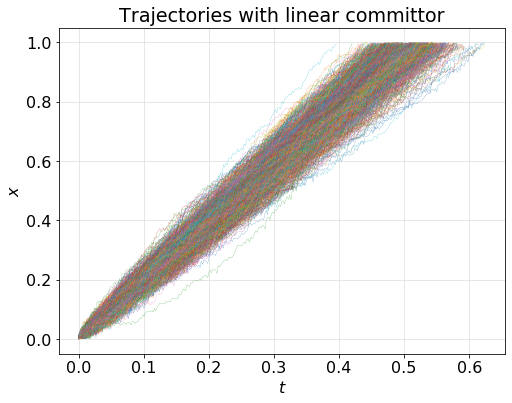

M
[[0.14142136 0.14142136]
 [0.14142136 0.14142136]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-26-9f7977a7414a>", line 44:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 1.11e-16, constraint violation: 0.00e+00, execution time: 0.002 s.
[0.5 0.5]

 Quadratic guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-24-4d18b01478f2>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

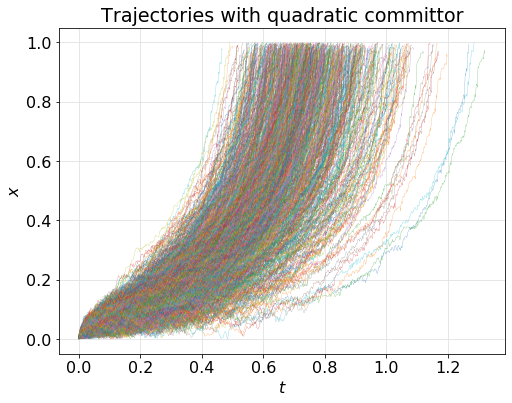

M
[[0.17285673 0.17285673]
 [0.17285673 0.17285673]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-26-9f7977a7414a>", line 119:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 1.11e-16, constraint violation: 0.00e+00, execution time: 0.0032 s.
[0.5 0.5]

 Cubic guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-24-4d18b01478f2>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

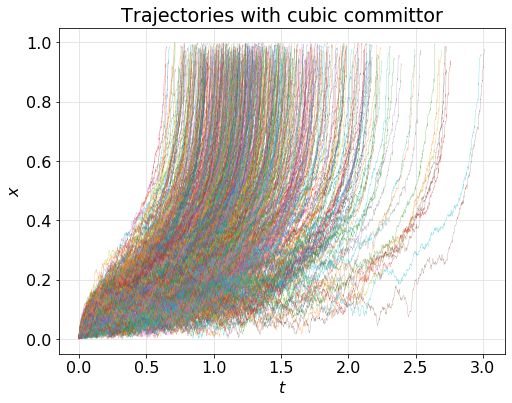

M
[[0.22377564 0.22377564]
 [0.22377564 0.22377564]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-26-9f7977a7414a>", line 194:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 1.11e-16, constraint violation: 0.00e+00, execution time: 0.002 s.
[0.5 0.5]

 Exp guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-24-4d18b01478f2>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


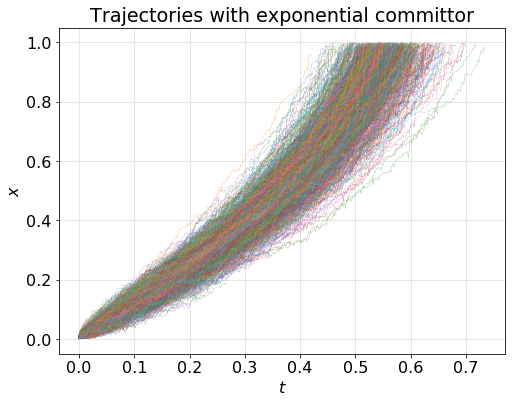

M
[[0.14335968 0.14335968]
 [0.14335968 0.14335968]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-26-9f7977a7414a>", line 269:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 1.67e-16, constraint violation: 0.00e+00, execution time: 0.002 s.
[0.5 0.5]

 Log guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-24-4d18b01478f2>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


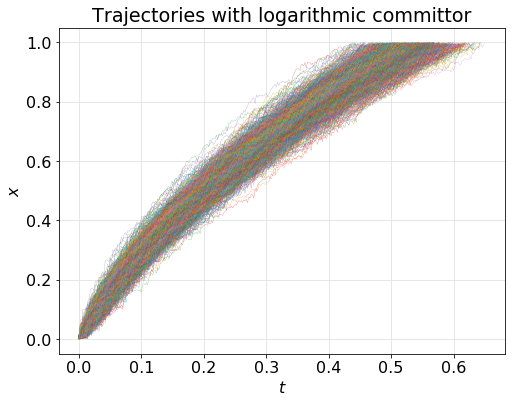

M
[[0.14178593 0.14178593]
 [0.14178593 0.14178593]]


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'I'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-26-9f7977a7414a>", line 346:
@njit(fastmath=True)
def I(c,M):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


`gtol` termination condition is satisfied.
Number of iterations: 1, function evaluations: 1, CG iterations: 0, optimality: 1.11e-16, constraint violation: 0.00e+00, execution time: 0.0022 s.
[0.5 0.5]


In [26]:
### Linear guess
print("Linear guess \n")
## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M, weights = LI_RMD_weights(Guess1 = qLin, dGuess1 = dqLin, Guess2 = qLin, dGuess2 = dqLin, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajLin = np.copy(traj)
            Mall = np.copy(M)
            weightsLin = np.copy(weights)
            tmp = 1
        if tmp==1:
            trajLin = np.concatenate((trajLin, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
            weightsLin = np.concatenate((weightsLin, weights), axis=0)
# Title and labels
plt.title('Trajectories with linear committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= np.sum(weightsLin)
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ILin = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Quadratic guess
print("\n Quadratic guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M, weights = LI_RMD_weights(Guess1 = qQuadr, dGuess1 = dqQuadr, Guess2 = qQuadr, dGuess2 = dqQuadr, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajQuadr = np.copy(traj)
            Mall = np.copy(M)
            weightsQuadr = np.copy(weights)
            tmp = 1
        if tmp==1:
            trajQuadr = np.concatenate((trajQuadr, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
            weightsQuadr = np.concatenate((weightsQuadr, weights), axis=0)
# Title and labels
plt.title('Trajectories with quadratic committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= np.sum(weightsQuadr)
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
IQuadr = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Cubic guess
print("\n Cubic guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M, weights = LI_RMD_weights(Guess1 = qCub, dGuess1 = dqCub, Guess2 = qCub, dGuess2 = dqCub, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajCub = np.copy(traj)
            Mall = np.copy(M)
            weightsCub = np.copy(weights)
            tmp = 1
        if tmp==1:
            trajCub = np.concatenate((trajCub, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
            weightsCub = np.concatenate((weightsCub, weights), axis=0)
# Title and labels
plt.title('Trajectories with cubic committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= np.sum(weightsCub)
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ICub = I(ctry,M)
## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

### Exp guess
print("\n Exp guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M, weights = LI_RMD_weights(Guess1 = qExp, dGuess1 = dqExp, Guess2 = qExp, dGuess2 = dqExp, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajExp = np.copy(traj)
            Mall = np.copy(M)
            weightsExp = np.copy(weights)
            tmp = 1
        if tmp==1:
            trajExp = np.concatenate((trajExp, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
            weightsExp = np.concatenate((weightsExp, weights), axis=0)
# Title and labels
plt.title('Trajectories with exponential committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= np.sum(weightsExp)
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
IExp = I(ctry,M)

## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)


### Log guess
print("\n Log guess \n")

## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M, weights = LI_RMD_weights(Guess1 = qLog, dGuess1 = dqLog, Guess2 = qLog, dGuess2 = dqLog, c = ctry,kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajLog = np.copy(traj)
            Mall = np.copy(M)
            weightsLog = np.copy(weights)
            tmp = 1
        if tmp==1:
            trajLog = np.concatenate((trajLog, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
            weightsLog = np.concatenate((weightsLog, weights), axis=0)
# Title and labels
plt.title('Trajectories with logarithmic committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(2):
        for j in range(2):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= np.sum(weightsLog)
    
print("M")
print(M)

@njit(fastmath=True)
def I(c,M):
    Iout=0.0
    for i in range(len(c)):
        for j in range(len(c)):
            Iout += M[i,j]*c[i]*c[j]
    return Iout

@njit(fastmath=True,parallel=True)
def I_der(c,M):
    Iout = np.zeros_like(c)
    for i in range(len(c)):
        for j in range(len(c)):
            Iout[i] += M[i,j]*c[j]
    return 2.0*Iout

@njit
def I_hess(c,M):
    return 2.0*M

## Value of I
ILog = I(ctry,M)

## Bonds for the minimization
bounds = Bounds([0.0, 0.0], [1.0, 1.0])
linear_constraint = LinearConstraint([1.0, 1.0], 1.0, 1.0)

res = minimize(I, [0.5, 0.5],M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=linear_constraint,
               options={'verbose': 1}, bounds=bounds)

print(res.x)

In [27]:
D = np.sqrt(2.0*KBT)
print("Linear")
print("Simulated I:= ",ILin)
print("Theoretical I:= ", D)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLin)):
    tmp = dqLin(np.random.uniform())
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2           
# Average M over all the values obtained with the sampling
M *= D/len(trajLin)
# Calculation of I based on the sampling of the linear committor
ILinResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ILinResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLin)):
    tmp = dqLin(trajLin[k])
    weight = tmp*np.exp(-potential(trajLin[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ILinReweight= I(ctry,M)
print("Reweighted distribution I:= ", ILinReweight)



print("\nQuadratic")
print("Simulated I:= ",IQuadr)
print("Theoretical I:= ", 4.0/3.0*D)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajQuadr)):
    tmp = dqQuadr(np.random.uniform())
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2  
# Average M over all the values obtained with the sampling
M *= D/len(trajQuadr)
# Calculation of I based on the sampling of the linear committor
IQuadrResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", IQuadrResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajQuadr)):
    tmp = dqQuadr(trajQuadr[k])
    weight = tmp*np.exp(-potential(trajQuadr[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
IQuadrReweight= I(ctry,M)
print("Reweighted distribution I:= ", IQuadrReweight)


print("\nCubic")
print("Simulated I:= ",ICub)
print("Theoretical I:= ", 9.0/5.0*D)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajCub)):
    tmp = dqCub(np.random.uniform())
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2        
# Average M over all the values obtained with the sampling
M *= D/len(trajCub)
# Calculation of I based on the sampling of the linear committor
ICubResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ICubResampled) 
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajCub)):
    tmp = dqCub(trajCub[k])
    weight = tmp*np.exp(-potential(trajCub[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ICubReweight= I(ctry,M)
print("Reweighted distribution I:= ", ICubReweight)


print("\nExponential")
print("Simulated I:= ",IExp)
print("Theoretical I:= ", D/2.0*(np.exp(2)-1.0)/(np.exp(1.0)-1.0)**2)
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajExp)):
    tmp = dqExp(np.random.uniform())
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2
# Average M over all the values obtained with the sampling
M *= D/len(trajExp)
# Calculation of I based on the sampling of the linear committor
IExpResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", IExpResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajExp)):
    tmp = dqExp(trajExp[k])
    weight = tmp*np.exp(-potential(trajExp[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
IExpReweight= I(ctry,M)
print("Reweighted distribution I:= ", IExpReweight)



print("\nLogarithmic")
print("Simulated I:= ",ILog)
print("Theoretical I:= ", D/(2.0*np.log(2.0)**2))
## Resampling of the transition values
# Sum all the values of M obtained with the sampling
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLog)):
    tmp = dqLog(np.random.uniform())
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2
# Average M over all the values obtained with the sampling
M *= (D/len(trajLog))
# Calculation of I based on the sampling of the linear committor
ILogResampled = I(ctry,M)
print("Resampled with correct distribution I:= ", ILogResampled)
## Reweighting of the transition values
# Sum all the values of M obtained with the sampling
weightsum = 0.0
M = np.zeros((2,2), dtype=np.float64)
for k in range(len(trajLog)):
    tmp = dqLog(trajLog[k])
    weight = tmp*np.exp(-potential(trajLog[k])/KBT)
    weightsum += weight
    for i in range(2):
        for j in range(2):
            M[i,j] += tmp**2*weight
# Average M over all the values obtained with the sampling
M *= D/weightsum
# Calculation of I based on the sampling of the linear committor
ILogReweight= I(ctry,M)
print("Reweighted distribution I:= ", ILogReweight)

Linear
Simulated I:=  0.14142135623778979
Theoretical I:=  0.1414213562373095
Resampled with correct distribution I:=  0.1414213562373095
Reweighted distribution I:=  0.1414213562373095

Quadratic
Simulated I:=  0.17285673491990813
Theoretical I:=  0.18856180831641267
Resampled with correct distribution I:=  0.1878674735168204
Reweighted distribution I:=  0.1728567349199077

Cubic
Simulated I:=  0.22377564185957952
Theoretical I:=  0.2545584412271571
Resampled with correct distribution I:=  0.25459876550497484
Reweighted distribution I:=  0.22377564185958085

Exponential
Simulated I:=  0.14335967634179134
Theoretical I:=  0.15301461330263805
Resampled with correct distribution I:=  0.15292012321308113
Reweighted distribution I:=  0.14335967634179175

Logarithmic
Simulated I:=  0.14178593201638343
Theoretical I:=  0.14717501206203998
Resampled with correct distribution I:=  0.14713476245531348
Reweighted distribution I:=  0.14178593201638753


In [28]:
def Boltz_sample_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M, weights = LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = c, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                weightsall = np.copy(weights)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
                weightsall = np.concatenate((weightsall, weights), axis=0)
        del traj, M, weights         
        
    # Evaluation of M
    M = np.zeros((2,2), dtype=np.float64)
    # Average all the values of M
    for k in range(Mall.shape[0]):
        for i in range(2):
            for j in range(2):
                M[i,j] += Mall[k,i,j]
            
    
    # Average M over all the values obtained with the sampling
    M /= np.sum(weightsall)

    # Minimization part
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=LinearConstraint([1.0, 1.0], 1.0, 1.0),
               options={'verbose': 0}, bounds=Bounds([0.0, 0.0], [1.0, 1.0]))
    
    
    return np.array(cout.x)

In [29]:
KR = 1000
KBT = 0.01
ctry = [0.5, 0.5]
DT = 0.002

In [30]:
c = Boltz_sample_weights(Guess1 = qQuadr, dGuess1 = dqQuadr, Guess2 = qQuadr, dGuess2 = dqQuadr, c = ctry ,kr=KR, KbT = KBT)
print(c)

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-24-4d18b01478f2>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactiv

In [31]:
def Self_consistent_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5, 0.5], dt = 0.002, KbT = 0.1, kr = 1000, isteps = 10000, jsteps = 1000, ksteps = 30, alpha = 0.5):       
    cout = np.empty((ksteps, 2), dtype=np.float64)
    # Save the initial conditions
    cout[0,0] = c[0]
    cout[0,1] = c[1]
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sample_weights(Guess1, dGuess1, Guess2, dGuess2, c = c, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sample_weights(Guess1, dGuess1, Guess2, dGuess2, c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

In [32]:
KR = 1000
KBT = 0.01
GUESS1 = qLin
DGUESS1 = dqLin
GUESS2 = qQuadr
DGUESS2 = dqQuadr

Cycle =  1
Cycle =  2


/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMD_weights'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-24-4d18b01478f2>", line 2:
@njit(fastmath=True)
def LI_RMD_weights(Guess1, dGuess1, Guess2, dGuess2, c = [0.5,0.5], dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  3
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!

No reactive trajectory found!
No reactive trajectory found!
Cycle =  25
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  26
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive traj

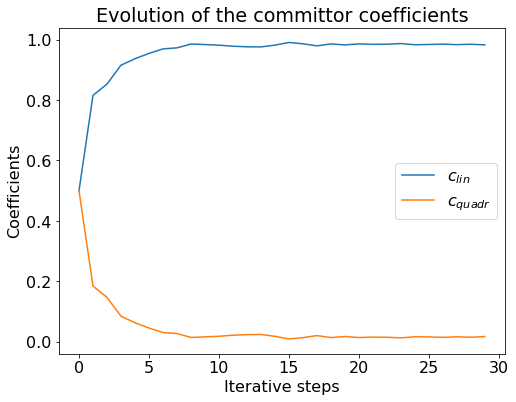

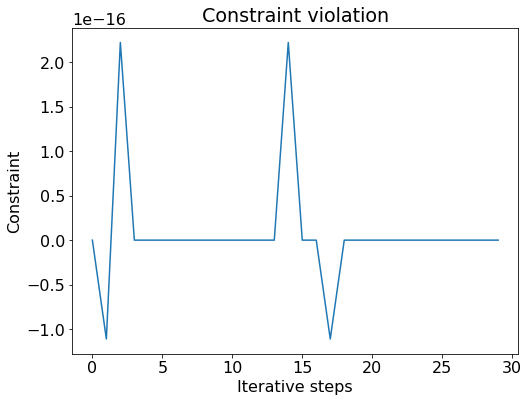

No handles with labels found to put in legend.


Final coefficients
[0.98259588 0.01740412]


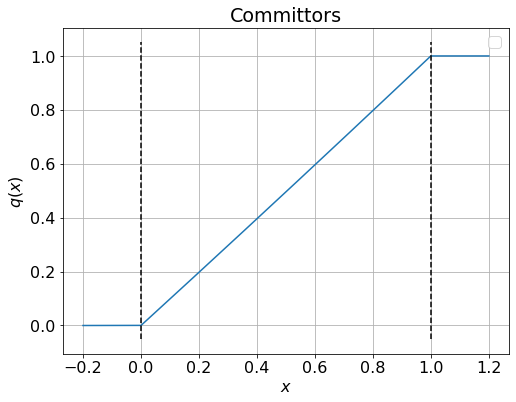

In [33]:
# Self consistent procedure
c = Self_consistent_weights(Guess1 = GUESS1, dGuess1 = DGUESS1, Guess2 = GUESS2, dGuess2 = DGUESS2,c = [0.5, 0.5], kr = KR, KbT = KBT)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(c[:,0], label = r"$c_{lin}$")
plt.plot(c[:,1], label = r"$c_{quadr}$")
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(c[:,0]+c[:,1] - 1.0)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:])
# Print the corresponding committor
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    y[i] = c[-1,0]*GUESS1(x[i]) + c[-1,1]*GUESS2(x[i])
plt.plot(x,y)
plt.plot(0.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.title('Committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.legend()
plt.grid()
plt.show()

### Linear combination of all the guesses

In [34]:
@njit(fastmath=True)
def ListGuess(n, q):
    if n == 0:
        return qLin(q)
    elif n == 1:
        return qQuadr(q)
    elif n == 2:
        return qCub(q)
    elif n == 3:
        return qExp(q)
    else:
        return qSqrt(q)
    
@njit(fastmath=True)
def ListdGuess(n, q):
    if n == 0:
        return dqLin(q)
    elif n == 1:
        return dqQuadr(q)
    elif n == 2:
        return dqCub(q)
    elif n == 3:
        return dqExp(q)
    else:
        return dqSqrt(q)

In [35]:
@njit(fastmath=True)
def LI_RMDN(c, dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
    ## Number of committor functions given as input
    n = len(c)
    
    # Define preliminary variables
    q = np.empty(isteps, dtype=np.float64)
    M = np.empty((isteps,n,n), dtype=np.float64)
    weights = np.empty(isteps, dtype=np.float64)
    dGx = np.empty(n, dtype=np.float64)
    
    q[0] = 0.001
    i = 0
    j = 0
    tmp = 0
    s = state(q[0]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmax = 0.0
    # Diffusion coefficient
    D = np.sqrt(2.0*KbT*dt)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        ## Evaluate evolution of the system
        f = force(q[i])
         # Evaluate z
        z = 0.0
        for k in range(n):
            z += c[k]*ListGuess(k, q[i])
        # Gradient components of the committors
        for k in range(n):
            dGx[k]= ListdGuess(k, q[i]) 
        # Reweight term
        gradcomm = 0.0
        for k in range(n):
            gradcomm += c[k]*dGx[k]
        weights[i] = gradcomm*np.exp(-potential(q[i])/KbT)
        # Evaluating M Matrix
        for k in range(n):
            for l in range(n):
                M[i,k,l] = dGx[k]*dGx[l]*weights[i]
        if z > zmax:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)
            zmax = z
        else:
            q[i+1] = q[i]+f*dt+D*np.random.normal(0,1)+kr*gradcomm*(zmax - z)*dt
        i += 1
        s = state(q[i])
    
    M *= np.sqrt(2.0*KbT)  # This line technically is not needed because later we rescale everything. Kept for consistency
    
    # Output in the case we do not find a reactive coordinate, so that the function does not crash
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty(1, dtype=np.float64)
        out[0] = 0.0
        outM = np.empty((1, n, n), dtype=np.float64)
        for k in range(n):
            for l in range(n):
                M[i,k,l] = 0.0
        outweights = np.empty(1, dtype=np.float64)
        outweights[0] = 0.0
        return out, outM, outweights
        
    return q[j+1:i-1], M[j+1:i-1,:,:], weights[j+1:i-1]

In [36]:
KR = 1000
KBT = 0.01
ctry = [1.0, 0.0, 0.0, 0.0, 0.0]
DT = 0.002

Linear guess 



/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMDN'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-35-330409615187>", line 2:
@njit(fastmath=True)
def LI_RMDN(c, dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


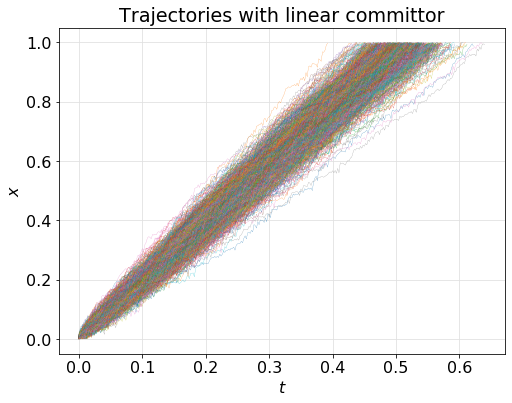

M
[[0.14142136 0.1411277  0.14074645 0.14123592 0.14048022]
 [0.1411277  0.18766194 0.21054055 0.16394612 0.09421056]
 [0.14074645 0.21054055 0.25195231 0.17612635 0.08456253]
 [0.14123592 0.16394612 0.17612635 0.15253691 0.11976938]
 [0.14048022 0.09421056 0.08456253 0.11976938 0.73754624]]


In [37]:
### Linear guess
print("Linear guess \n")
## Runs of the Langevin dynamics
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
tmp = 0
# Loop over many iterations with different initial conditions
for i in range(1000):
    traj, M, weights = LI_RMDN(c = ctry, kr = KR, KbT = KBT, dt = DT)
    if traj[0] != 0:
        plt.plot(np.arange(len(traj))*DT,traj, linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            Mall = np.copy(M)
            weightsall = np.copy(weights)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
            Mall = np.concatenate((Mall, M), axis=0)
            weightsall = np.concatenate((weightsall, weights), axis=0)
# Title and labels
plt.title('Trajectories with linear committor')
plt.xlabel('$t$')
plt.ylabel('$x$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Evaluation of M
n = len(ctry)
M = np.zeros((n,n), dtype=np.float64)
for k in range(Mall.shape[0]):
    for i in range(n):
        for j in range(n):
            M[i,j] += Mall[k,i,j]
            
# Average M over all the values obtained with the sampling
M /= np.sum(weightsall)
    
print("M")
print(M)

In [38]:
def Boltz_sampleN(c, dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000, jsteps = 1000):
    # Sampling of transition region
    tmp = 0
    for j in range(jsteps):
        traj, M, weights = LI_RMDN(c = c, dt = dt, KbT = KbT, kr = kr, isteps= isteps)
        if traj[0] != 0:
            if tmp==0:
                trajall = np.copy(traj)
                Mall = np.copy(M)
                weightsall = np.copy(weights)
                tmp = 1
            if tmp==1:
                trajall = np.concatenate((trajall, traj), axis=0)
                Mall = np.concatenate((Mall, M), axis=0)
                weightsall = np.concatenate((weightsall, weights), axis=0)
        del traj, M, weights
    
    # Evaluation of M
    n = len(ctry)
    M = np.zeros((n,n), dtype=np.float64)
    for k in range(Mall.shape[0]):
        for i in range(n):
            for j in range(n):
                M[i,j] += Mall[k,i,j]
            
    # Average M over all the values obtained with the sampling
    M /= np.sum(weightsall)
    
    # Matrices used for the minimization procedure
    A = [1.0 for i in range(n)]
    B = [0.0 for i in range(n)]
    # Minimization procedure
    cout = minimize(I, c, M, method='trust-constr', jac=I_der, hess=I_hess,
               constraints=LinearConstraint(A, 1.0, 1.0),
               options={'verbose': 0}, bounds=Bounds(B, A))
    
    
    return np.array(cout.x)

In [39]:
c = Boltz_sampleN(c = [0.2, 0.2, 0.2, 0.2, 0.2], kr=KR, KbT = KBT)
print(c)

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'c' of function 'LI_RMDN'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-35-330409615187>", line 2:
@njit(fastmath=True)
def LI_RMDN(c, dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
[8.87561694e-01 1.78704793e-05 1.08725563e-01 3.65231009e-03
 4.25625040e-05]


In [40]:
def Self_consistentN(c, dt = 0.002, KbT = 0.01, kr = 1000, isteps = 10000, jsteps = 1000, ksteps = 30, alpha = 0.5):       
    n = len(c)
    cout = np.empty((ksteps, n), dtype=np.float64)
    for i in range(n):
        cout[0,i] = c[i]
    
    print("Cycle = ", 1)
    # I do the first iteration
    print("Cycle = ", 2)
    cout[1,:] = Boltz_sampleN(c = c, dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    # I iterate the previous procedure many times
    for k in range(ksteps - 2):
        print("Cycle = ", k + 3)
        cout[k+2,:] = Boltz_sampleN(c = alpha*cout[k+1,:] + (1.0 - alpha)*cout[k,:], dt = dt, KbT = KbT, kr = kr, isteps = isteps, jsteps = jsteps)
    
    return cout

In [41]:
KR = 1000
KBT = 0.01
ctry = [0.2, 0.2, 0.2, 0.2, 0.2]
n = 5

Cycle =  1
Cycle =  2
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  3
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  4
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  5
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive tra

No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
Cycle =  30
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!
No reactive trajectory found!


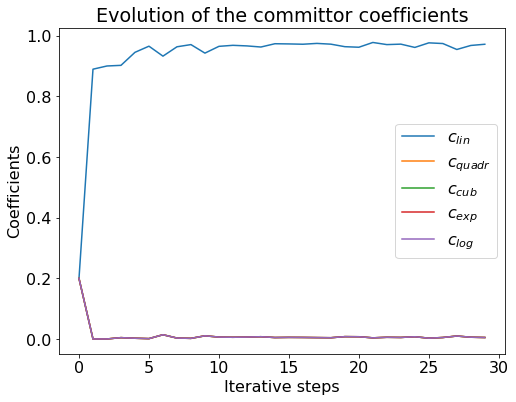

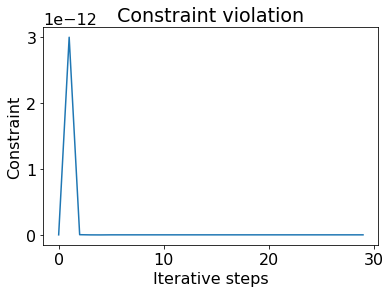

Final coefficients
[0.97218088 0.00530264 0.00439625 0.0163128  0.00180742]


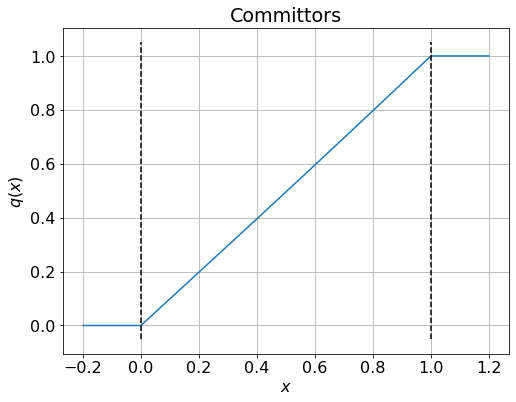

In [42]:
# Self consistent procedure
c = Self_consistentN(c = ctry, kr = KR, KbT = KBT)

# Plot of the evolution of the coefficients during the self consistent procedure
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
plt.plot(c[:,0], label = r"$c_{lin}$")
plt.plot(c[:,1], label = r"$c_{quadr}$")
plt.plot(c[:,1], label = r"$c_{cub}$")
plt.plot(c[:,1], label = r"$c_{exp}$")
plt.plot(c[:,1], label = r"$c_{log}$")
plt.title("Evolution of the committor coefficients")
plt.xlabel("Iterative steps")
plt.ylabel("Coefficients")
plt.legend()
plt.show()

# Plot of how much we violate the linear constraint
constraint = np.zeros_like(c[:,0])
for i in range(c.shape[1]):
    constraint[i] = np.sum(c[i,:])-1.0
plt.figure()
plt.plot(constraint)
plt.title("Constraint violation")
plt.xlabel("Iterative steps")
plt.ylabel("Constraint")
plt.show()

# Plot the final results
print("Final coefficients")
print(c[-1,:])
# Print the corresponding committor
x = np.linspace(-0.2,1.2,1000)
y = np.zeros_like(x)
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 16})
for i in range(len(x)):
    for j in range(n): 
        y[i] += c[-1,j]*ListGuess(j,x[i])
plt.plot(x,y)
plt.plot(0.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.plot(1.0*np.ones(2),np.linspace(-0.05,1.05,2),"k--")
plt.title('Committors')
plt.xlabel(r'$x$')
plt.ylabel(r'$q(x)$')
plt.grid()
plt.show()